In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev, BSpline
import sys
sys.path.append('../')
from package_global_functions import *
from filesHandling_quenched import *
from percolationAnalysis import getMeanClusterSize_ir

In [4]:
def linFunc(x, a, b):
    return a*x + b

def powerLaw(x,a,b):
    return a*x**b

# old version using symetric around_maxs
def meanClusterSize_w_splines(arena_r, exclusion_r, Ns, around_maxs, ss, eps=None, eps_shade=None, push = False):
    pushLabel = 'push' if push else 'nopush'
    fig, ax = plt.subplots()
    colors = plt.cm.gnuplot(np.linspace(0,0.95,len(Ns)))
    percs_from_spline, ebars_from_spline = [], []
    ax.set(xlabel=r'$r_{int}$', ylabel='MCS')
    zipper = zip(Ns, ss, around_maxs, colors, arena_r) if isinstance(arena_r, list) else zip(Ns, ss, around_maxs, colors)
    # for N,s,around_max,color in zip(Ns, ss, around_maxs, colors):
    for z in zipper:
        if isinstance(arena_r, list):
            N,s,around_max,color,ar = z
        else:
            N,s,around_max,color = z
            ar = arena_r
        irs = availableIrs(N, ar, exclusion_r, push)
        dfmcs = getMeanClusterSize_ir(N, ar, exclusion_r, irs, push)
        ax.plot(dfmcs['interac_r'], dfmcs['mcs'], label=f'{N}', marker='.', lw=0.4, color=color, alpha=0.5)
        maxMCS = max(dfmcs['mcs'])
        i = dfmcs[dfmcs.mcs == maxMCS].index[0]
        irs_spline, mcs_spline = np.array(dfmcs.iloc[i-around_max:i+around_max+1].interac_r), np.array(dfmcs.iloc[i-around_max:i+around_max+1].mcs)
        tck_s = splrep(irs_spline, mcs_spline, s=s)
        ax.plot(irs_spline, BSpline(*tck_s)(irs_spline), '-', color=color)
        irs_interp = np.linspace(irs_spline[0],irs_spline[-1],500)
        mcs_interp = splev(irs_interp,tck_s)
        maxMCS = max(mcs_interp)
        index_maxMCS = max(range(len(mcs_interp)), key=mcs_interp.__getitem__)
        perc_ir = irs_interp[index_maxMCS]
        percs_from_spline.append(perc_ir)
        ax.plot(perc_ir, maxMCS, marker='x', markersize=4, color=color)
        # get the errorbars for percs_from_spline with the derivative criterion:
        if eps:
            h = irs_interp[1] - irs_interp[0]
            mcs_interp_der = (np.array(mcs_interp[2:]) - np.array(mcs_interp[:-2]))/(2*h)
            mcs_interp_der = np.insert(mcs_interp_der, 0, (mcs_interp[1] - mcs_interp[0])/h, axis=0)
            mcs_interp_der = np.append(mcs_interp_der, (mcs_interp[-1]-mcs_interp[-2])/h)
            irs_interp_der_eps = irs_interp[np.abs(mcs_interp_der) < eps]
            mcs_interp_der_eps = mcs_interp[np.abs(mcs_interp_der) < eps]
            ax.fill_between(irs_interp_der_eps, mcs_interp_der_eps-eps_shade, mcs_interp_der_eps+eps_shade, color=color, alpha=0.1)
            min_ir, max_ir = irs_interp_der_eps[0], irs_interp_der_eps[-1]
            ebars_from_spline.append((min_ir, max_ir))
    fig.legend(title='N', fontsize=8)
    fig.tight_layout()
    fig.savefig(f'MCS_difN_ar_{arena_r}_er_{exclusion_r}_{pushLabel}_splineMAX.png')
    if eps:
        return percs_from_spline, ebars_from_spline
    else:
        return percs_from_spline

# new version using asymetric, below_maxs and above_maxs
def meanClusterSize_w_splines_new(arena_r, exclusion_r, Ns, below_maxs, above_maxs, ss, eps = None, eps_shade = None, push = False):
    pushLabel = 'push' if push else 'nopush'
    fig, ax = plt.subplots()
    colors = plt.cm.gnuplot(np.linspace(0,0.95,len(Ns)))
    percs_from_spline, ebars_from_spline = [], []
    ax.set(xlabel=r'$r_{int}$', ylabel='MCS')
    zipper = zip(Ns, ss, below_maxs, above_maxs, colors, arena_r) if isinstance(arena_r, list) else zip(Ns, ss, below_maxs, above_maxs, colors)
    # for N,s,around_max,color in zip(Ns, ss, around_maxs, colors):
    for z in zipper:
        if isinstance(arena_r, list):
            N,s,below_max,above_max,color,ar = z
        else:
            N,s,below_max,above_max,color = z
            ar = arena_r
        irs = availableIrs(N, ar, exclusion_r, push)
        dfmcs = getMeanClusterSize_ir(N, ar, exclusion_r, irs, push)
        ax.plot(dfmcs['interac_r'], dfmcs['mcs'], label=f'{N}', marker='.', lw=0.4, color=color, alpha=0.5)
        maxMCS = max(dfmcs['mcs'])
        i = dfmcs[dfmcs.mcs == maxMCS].index[0]
        irs_spline, mcs_spline = np.array(dfmcs.iloc[i-below_max:i+above_max+1].interac_r), np.array(dfmcs.iloc[i-below_max:i+above_max+1].mcs)
        tck_s = splrep(irs_spline, mcs_spline, s=s)
        irs_interp = np.linspace(irs_spline[0],irs_spline[-1],500)
        mcs_interp = splev(irs_interp,tck_s)
        ax.plot(irs_interp, BSpline(*tck_s)(irs_interp), '-', color=color, lw=0.9)
        maxMCS = max(mcs_interp)
        index_maxMCS = max(range(len(mcs_interp)), key=mcs_interp.__getitem__)
        perc_ir = irs_interp[index_maxMCS]
        percs_from_spline.append(perc_ir)
        ax.plot(perc_ir, maxMCS, marker='x', markersize=4, color=color)
        # get the errorbars for percs_from_spline with the derivative criterion:
        if eps:
            h = irs_interp[1] - irs_interp[0]
            mcs_interp_der = (np.array(mcs_interp[2:]) - np.array(mcs_interp[:-2]))/(2*h)
            mcs_interp_der = np.insert(mcs_interp_der, 0, (mcs_interp[1] - mcs_interp[0])/h, axis=0)
            mcs_interp_der = np.append(mcs_interp_der, (mcs_interp[-1]-mcs_interp[-2])/h)
            irs_interp_der_eps = irs_interp[np.abs(mcs_interp_der) < eps]
            mcs_interp_der_eps = mcs_interp[np.abs(mcs_interp_der) < eps]
            ax.fill_between(irs_interp_der_eps, mcs_interp_der_eps-eps_shade, mcs_interp_der_eps+eps_shade, color=color, alpha=0.1)
            min_ir, max_ir = irs_interp_der_eps[0], irs_interp_der_eps[-1]
            ebars_from_spline.append((min_ir, max_ir))
    fig.legend(title='N', fontsize=8)
    fig.tight_layout()
    fig.savefig(f'MCS_difN_ar_{arena_r}_er_{exclusion_r}_{pushLabel}_splineMAX.png')
    if eps:
        return percs_from_spline, ebars_from_spline
    else:
        return percs_from_spline

#############

# old version, fitting raw data to a power law
def ri_star_N_fit(arena_r, exclusion_r, Ns, percs_from_spline, func, p0in = None, push = False, logscale = False, eyerule=1.0, err_percs_from_spline = None):
    from scipy.optimize import curve_fit
    pushLabel = 'push' if push else 'nopush'
    paramfit, covfit = curve_fit(func, Ns, percs_from_spline, p0=p0in)
    fit = func(Ns, *paramfit)
    fig, ax = plt.subplots()
    if isinstance(err_percs_from_spline, list):
        ax.errorbar(Ns, percs_from_spline, err_percs_from_spline, lw=0.7, marker='.', elinewidth=0.7, capsize=3)
    else:
        ax.plot(Ns, percs_from_spline, marker='.', lw=0.7)
    ax.plot(Ns, fit, ls='-.', lw=0.8, color='k')
    ax.plot(Ns, eyerule*np.array(Ns)**(-1/2), ls='-.', color='xkcd:red', lw=0.9)
    ax.text(0.6, 0.6, rf'{round(paramfit[0],3)} N**({round(paramfit[1],3)})', fontsize=8, color='k', transform=ax.transAxes)
    ax.text(0.6, 0.55, rf'{round(paramfit[1],8)} +- {round(np.sqrt(covfit[1,1]),8)}', fontsize=8, color='k', transform=ax.transAxes)
    ax.set(xlabel='N', ylabel=r'$r_{int}^{*}$')
    fig.tight_layout()
    figname = f'percR_MCS_difN_ri_star_N_fit_ar_{arena_r}_er_{exclusion_r}_{pushLabel}'
    if logscale:
        figname += '_logscale'
    figname += '_from_splineMAX.png'
    fig.savefig(figname)
    return paramfit

# new version, fitting log of data to a linear function
def ri_star_N_fit_new(arena_r, exclusion_r, Ns, percs_from_spline, p0in = None, push = False, eyerule=None, err_percs_from_spline = None):
    from scipy.optimize import curve_fit
    pushLabel = 'push' if push else 'nopush'
    # fit log log to a linear
    paramfit, covfit = curve_fit(linFunc, np.log(Ns), np.log(percs_from_spline), p0=p0in)
    # transform the parameters to those of the power law
    const = np.exp(paramfit[1])
    exponent = paramfit[0]
    fit = powerLaw(np.array(Ns), const, exponent)
    # another option with the fit is to do this...
    # fit = linFunc(np.log(np.array(Ns)), *paramfit)
    # fit = np.exp(fit)
    # ax.plot(Ns, fit, ls='-.', color='k', lw=0.7)
    fig, ax = plt.subplots()
    if isinstance(err_percs_from_spline, list):
        ax.errorbar(Ns, percs_from_spline, err_percs_from_spline, lw=0.7, marker='.', elinewidth=0.7, capsize=3)
    else:
        ax.plot(Ns, percs_from_spline, marker='.', lw=0.7)
    ax.plot(Ns, fit, ls='-.', lw=0.8, color='k')
    if eyerule:
        ax.plot(Ns, eyerule*np.array(Ns)**(-1/2), ls='-.', color='xkcd:red', lw=0.9)
    ax.text(0.6,0.6, fr'$r_{{int}}^* \simeq {round(const,4)} \; N^{{{round(exponent,4)}}}$', transform=ax.transAxes)
    ax.set(xlabel='N', ylabel='$r_{int}^*$', xscale='log', yscale='log')
    fig.tight_layout()
    figname = f'percR_MCS_difN_ri_star_N_fit_ar_{arena_r}_er_{exclusion_r}_{pushLabel}'
    figname += '_logscale'
    figname += '_from_splineMAX.png'
    fig.savefig(figname)
    return paramfit

#############

def p_star_FSC_check(arena_r, exclusion_r, Ns, percs_from_spline, func, p0in = None, push = False, logscale = False, err_percs_from_spline = None):
    from scipy.optimize import curve_fit
    pushLabel = 'push' if push else 'nopush'
    # Finite size scaling
    nu, df = 4/3, 182/96
    Ns_fsc = np.array(Ns)**(-1/(nu*df))
    if isinstance(arena_r, list):
        y_axis = [N*(ri_star/ar)**2 for N,ri_star,ar in zip(Ns,percs_from_spline, arena_r)]
    else:
        y_axis = [N*(ri_star/arena_r)**2 for N,ri_star in zip(Ns,percs_from_spline)]
    paramfit, covfit = curve_fit(func, Ns_fsc, y_axis, p0=p0in)
    fit = func(Ns_fsc, *paramfit)
    fig, ax = plt.subplots()
    ax.plot(Ns_fsc, y_axis, marker='.', lw=0.7)
    ax.plot(Ns_fsc, fit, ls='-.', lw=0.8, color='k')
    ax.text(0.65, 0.35, rf'${round(paramfit[0],3)}*N^{{-1/(\nu d_f)}} + {round(paramfit[1],3)}$', fontsize=9, color='k', transform=ax.transAxes)
    # ax.text(0.6, 0.55, rf'{round(paramfit[1],8)} +- {round(np.sqrt(covfit[1,1]),8)}', fontsize=8, color='k', transform=ax.transAxes)
    ax.set(xlabel=r'$N^{-1/(\nu d_f)}$', ylabel=r'$N(r_{int}^* / R)^2$') # , xscale='log', yscale='log'
    fig.tight_layout()
    figname = f'percR_MCS_difN_p_star_Nexpos_check_ar_{arena_r}_er_{exclusion_r}_{pushLabel}'
    if logscale:
        figname += '_logscale'
    figname += '_from_splineMAX_FSC.png'
    fig.savefig(figname)

def p_star_FSC_fit(arena_r, exclusion_r, Ns, percs_from_spline, func, p0in = None, push = False):
    from scipy.optimize import curve_fit
    pushLabel = 'push' if push else 'nopush'
    # Finite size scaling theoretical parameters
    nu, df = 4/3, 182/96
    # expected exponents:
    exp = -1/(nu*df)
    # print(f'Expected exponent: {exp}')
    if isinstance(arena_r, list):
        y_axis = [N*(ri/ar)**2 for N,ri,ar in zip(Ns,percs_from_spline,arena_r)]
    else:
        y_axis = [N*(ri/arena_r)**2 for N,ri in zip(Ns,percs_from_spline)]
    paramfit, covfit = curve_fit(func, Ns, y_axis, p0 = p0in)
    fit = func(Ns, *paramfit)
    fig, ax = plt.subplots()
    ax.plot(Ns, y_axis, marker='.', lw=0.7)
    ax.plot(Ns, fit, ls='-.', lw=0.8, color='k')
    # ax.text(0.6, 0.45, rf'${round(paramfit[0],3)}*N^{{{round(paramfit[1],3)}}}$', fontsize=8, color='k', transform=ax.transAxes)
    ax.text(0.6, 0.45, rf'${round(paramfit[0],3)}*N^{{{round(paramfit[1],3)}}} + {round(paramfit[2],3)}$', fontsize=8, color='k', transform=ax.transAxes)
    ax.text(0.4, 0.55, fr'expected exponent $-1/ \nu d_f = {round(-1/(nu * df), 5)}$', fontsize = 8, color='k', transform=ax.transAxes)
    ax.set(xlabel=r'$N$', ylabel=r'$N (r_{int}^* / R)^2$', xscale='log', yscale='log')
    fig.tight_layout()
    figname = f'percR_MCS_difN_p_star_Nexpos_fit_ar_{arena_r}_er_{exclusion_r}_{pushLabel}'
    figname += '_from_splineMAX_FSC.png'
    fig.savefig(figname)

def provant(arena_r, exclusion_r, Ns, percs_from_spline, pinf, func, p0in = None, push = False):
    from scipy.optimize import curve_fit
    pushLabel = 'push' if push else 'nopush'
    # Finite size scaling theoretical parameters
    nu, df = 4/3, 182/96
    # expected exponents:
    exp = -1/(nu*df)
    # print(f'Expected exponent: {exp}')
    if isinstance(arena_r, list):
        y_axis = [np.log(N*(ri/ar)**2 - pinf) for N,ri,ar in zip(Ns,percs_from_spline,arena_r)]
    else:
        y_axis = [np.log(N*(ri/arena_r)**2 - pinf) for N,ri in zip(Ns,percs_from_spline)]
    paramfit, covfit = curve_fit(func, np.log(Ns), y_axis, p0 = p0in)
    fit = func(np.log(Ns), *paramfit)
    fig, ax = plt.subplots()
    ax.plot(np.log(Ns), y_axis, marker='.', lw=0.7)
    ax.plot(np.log(Ns), fit, ls='-.', lw=0.8, color='k')
    ax.text(0.6, 0.65, rf'${round(paramfit[0],3)}*log(N) + {{{round(paramfit[1],3)}}}$', fontsize=8, color='k', transform=ax.transAxes)
    ax.text(0.4, 0.75, fr'expected exponent $-1/ \nu d_f = {round(-1/(nu * df), 5)}$', fontsize = 8, color='k', transform=ax.transAxes)
    ax.set(xlabel=r'$log \; N$', ylabel=r'$log \; (N (r_{int}^* / R)^2 - p_{\infty})$') # , xscale='log', yscale='log'
    fig.tight_layout()
    figname = f'trial_pinf_fit_exponent_ar_{arena_r}_er_{exclusion_r}_{pushLabel}_pinf_{pinf}.png'
    fig.savefig(figname)

## arena 20.0, N around 35

In [ ]:
# arena_r, exclusion_r, Ns = 20.0, 1.5, [15, 20, 25, 30, 35, 40, 50, 60, 70, 80]
# around_maxs = [5,5,5,5,5,4,4,4,4,4]
# ss = [1,2,7,3,3,3,3,3,3,3]

# percs_from_spline_ar_20, ebars_from_spline_ar_20 = meanClusterSize_w_splines(arena_r, exclusion_r, Ns, around_maxs, ss, eps=0.15, eps_shade=0.5)

arena_r, exclusion_r, Ns = 20.0, 1.5, [15, 20, 25, 30, 35, 40, 50, 60, 70, 80]
below_maxs = [5,6,4,6,6,5,6,4,4,4]
above_maxs = [5,5,6,5,8,3,4,4,4,4]
ss = [1,2,7,3,3,5,3,3,3,4]

percs_from_spline_ar_20, ebars_from_spline_ar_20 = meanClusterSize_w_splines_new(arena_r, exclusion_r, Ns, below_maxs, above_maxs, ss, 
                                                                                 eps=0.15, eps_shade=0.5)

In [ ]:
# def powerLaw(x,a,b,c):
#     return a*x**b + c
# paramfit = ri_star_N_fit(arena_r, exclusion_r, Ns, percs_from_spline_ar_20, powerLaw, p0in = (70.0, -0.6, 0.0))


def powerLaw(x,a,b):
    return a*x**b

percs_error = [(e[1]-e[0])/2 for e in ebars_from_spline_ar_20]
paramfit = ri_star_N_fit(arena_r, exclusion_r, Ns, percs_from_spline_ar_20, powerLaw, eyerule=36, err_percs_from_spline=percs_error)

print(paramfit)

In [ ]:
percs_error = [(e[1]-e[0])/2 for e in ebars_from_spline_ar_20]

ri_star_N_fit_new(arena_r, exclusion_r, Ns, percs_from_spline_ar_20, err_percs_from_spline=percs_error)

In [ ]:
def linFunc(x,a,b):
    return a*x+b

p_star_FSC_check(arena_r, exclusion_r, Ns, percs_from_spline_ar_20, linFunc)

In [ ]:
# def powerLaw_pstar(N,a,b,c):
#     return a*N**b + c

# p_star_FSC_fit(arena_r, exclusion_r, Ns, percs_from_spline_ar_20, powerLaw_pstar, p0in=(20.0, -1.4, 1.0))

nu, df = 4/3, 182/96
fig, ax = plt.subplots()

# y_axis = [np.log(N*(ri/arena_r)**2 - 2.0) for N,ri in zip(Ns,percs_from_spline_ar_20)]
# ax.plot(np.log(Ns), y_axis, marker='.', lw=0.7)
# theo = 6.0*np.array(Ns)**(-1/(nu*df))
# ax.plot(np.log(Ns), np.log(theo), ls='-.', color='k')


# pinf_trial = 0.4
# const = 15.0
# y_axis = [np.log(N*(ri/arena_r)**2 - pinf_trial) for N,ri in zip(Ns,percs_from_spline_ar_20)]
# ax.plot(np.log(Ns), y_axis, marker='.', lw=0.7, color='xkcd:blue')
# theo = const*np.array(Ns)**(-1/(nu*df))
# ax.plot(np.log(Ns), np.log(theo), ls='-.', color='xkcd:red', lw=0.9)
# ax.text(0.6, 0.6, rf'${const} \; N^{{-1/( \nu d_f)}}$', transform = ax.transAxes, color='xkcd:red')
# ax.text(0.6, 0.52, rf'$p_{{\infty}}^* = {pinf_trial}$', transform = ax.transAxes, color='xkcd:blue')

from scipy.optimize import curve_fit
def origen(x,b):
    return -nu*np.log(x) + b


pinf_trials = [0.0, 0.4, 1.1, 2.0] # , 3.0
consts = [16.0, 14.0, 11.0, 6.0] # , 2.0
colors = plt.cm.gnuplot(np.linspace(0,0.95,len(pinf_trials)))

for pinf,const,c in zip(pinf_trials,consts,colors):
    y_axis = [np.log(N*(ri/arena_r)**2 - pinf) for N,ri in zip(Ns,percs_from_spline_ar_20)]
    ax.plot(np.log(Ns), y_axis, marker='.', lw=0.7, color=c, label=f'{pinf}')
    # b, covb = curve_fit(origen, Ns, y_axis)
    # print(np.exp(b))
    theo = const*np.array(Ns)**(-1/(nu*df))
    ax.plot(np.log(Ns), np.log(theo), ls='-.', color=c, lw=0.9)

fig.legend(title=r'$p_{{\infty}}^*$', loc=(0.2,0.2))
ax.set(xlabel='$log \; N$', ylabel='$log \; (p^{*} - p_{{\infty}}^*)$') # xscale='log', yscale='log'
fig.tight_layout()
fig.savefig(f'trial_pinf_ar_{arena_r}_er_{exclusion_r}_nopush.png')

In [ ]:
nu, df = 4/3, 182/96
fig, ax = plt.subplots()

from scipy.optimize import curve_fit

pinf_trials = [0.0, 0.4, 1.1]
# colors = plt.cm.gnuplot(np.linspace(0.05,0.95,len(pinf_trials)))
# use colors from last cell
colors = plt.cm.gnuplot(np.linspace(0,0.95,4))[:-1]
ytext_pos = [0.2, 0.25, 0.3]

for pinf,c,ypos in zip(pinf_trials,colors,ytext_pos):
    y_axis = [np.log(N*(ri/arena_r)**2 - pinf) for N,ri in zip(Ns,percs_from_spline_ar_20)]
    ax.plot(np.log(Ns), y_axis, marker='.', lw=0.7, color=c, label=f'{pinf}')
    paramfit, covfit = curve_fit(linFunc, np.log(Ns), y_axis)
    fit = linFunc(np.log(Ns), *paramfit)
    ax.plot(np.log(Ns), fit, ls='-.', color=c, lw=0.9)
    fig.text(0.2, ypos, fr'${round(paramfit[0],4)} \; log(N) + {round(paramfit[1],4)}$', color=c)


fig.text(0.15, 0.35, f'Expected exponnent (slope): ${round(-1/(nu*df),4)}$')
fig.legend(title=r'$p_{{\infty}}^*$', loc=(0.75,0.75))
ax.set(xlabel='$log \; N$', ylabel='$log \; (p^{*} - p_{{\infty}}^*)$') # xscale='log', yscale='log'
fig.tight_layout()
fig.savefig(f'trial_pinf_fitting_slope_ar_{arena_r}_er_{exclusion_r}_nopush.png')

In [ ]:
def linFunc(N,a,b):
    return a*N + b


# p_star_FSC_fit(arena_r, exclusion_r, Ns, percs_from_spline_ar_20, powerLaw_pstar, p0in=(20.0, -1.4, 1.0))

provant(arena_r, exclusion_r, Ns[0:], percs_from_spline_ar_20[0:], 0.0, linFunc)
provant(arena_r, exclusion_r, Ns[0:], percs_from_spline_ar_20[0:], 0.4, linFunc)
provant(arena_r, exclusion_r, Ns[0:], percs_from_spline_ar_20[0:], 0.417, linFunc)
provant(arena_r, exclusion_r, Ns[0:], percs_from_spline_ar_20[0:], 1.1, linFunc)

## arena 75.0, N around 492

In [ ]:
# arena_r, exclusion_r, Ns = 75.0, 1.5, [352, 492, 633, 703, 844, 984]
# ss = [2,10,13,7,7,7]
# around_maxs = [6,5,5,3,3,3]
# percs_from_spline_ar_75, ebars_from_spline_ar_75 = meanClusterSize_w_splines(arena_r, exclusion_r, Ns, around_maxs, ss, eps=10.0, eps_shade=5.0)

arena_r, exclusion_r, Ns = 75.0, 1.5, [352, 492, 633, 703, 844, 984]
ss = [2,10,10,12,12,7]
below_maxs = [7,5,3,3,3,3]
above_maxs = [6,3,4,3,4,3]

# arena_r, exclusion_r, Ns = 75.0, 1.5, [844, ]
# ss = [12,]
# below_maxs = [3,]
# above_maxs = [4,]

percs_from_spline_ar_75, ebars_from_spline_ar_75 = meanClusterSize_w_splines_new(arena_r, exclusion_r, Ns, below_maxs, above_maxs, ss, 
                                                                                 eps=10.0, eps_shade=7.0)

In [ ]:
def powerLaw(x,a,b):
    return a*x**b
paramfit = ri_star_N_fit(arena_r, exclusion_r, Ns, percs_from_spline_ar_75, powerLaw, eyerule=140)

print(paramfit)

In [ ]:
percs_error = [(e[1]-e[0])/2 for e in ebars_from_spline_ar_75]

ri_star_N_fit_new(arena_r, exclusion_r, Ns, percs_from_spline_ar_75, err_percs_from_spline=percs_error)

In [ ]:
def linFunc(x,a,b):
    return a*x+b

p_star_FSC_check(arena_r, exclusion_r, Ns, percs_from_spline_ar_75, linFunc)

In [ ]:
fig, ax = plt.subplots()

nu, df = 4/3, 182/96

from scipy.optimize import curve_fit
def origen(x,b):
    return -nu*np.log(x) + b


pinf_trials = [0.0, 0.4, 1.1, 2.0] # , 3.0
consts = [95.0, 85.0, 79.0, 62.0] # , 2.0
colors = plt.cm.gnuplot(np.linspace(0,0.95,len(pinf_trials)))

for pinf,const,c in zip(pinf_trials,consts,colors):
    y_axis = [np.log(N*(ri/arena_r)**2 - pinf) for N,ri in zip(Ns,percs_from_spline_ar_20)]
    ax.plot(np.log(Ns), y_axis, marker='.', lw=0.7, color=c, label=f'{pinf}')
    # b, covb = curve_fit(origen, Ns, y_axis)
    # print(np.exp(b))
    theo = const*np.array(Ns)**(-1/(nu*df))
    ax.plot(np.log(Ns), np.log(theo), ls='-.', color=c, lw=0.9)

fig.legend(title=r'$p_{{\infty}}^*$', loc=(0.2,0.2))
ax.set(xlabel='$log \; N$', ylabel='$log \; (p^{*} - p_{{\infty}}^*)$') # xscale='log', yscale='log'
fig.tight_layout()
fig.savefig(f'trial_pinf_ar_{arena_r}_er_{exclusion_r}_nopush.png')

In [ ]:
# def powerLaw_pstar(N,a,b,c):
#     return a*N**b + c

# p_star_FSC_fit(arena_r, exclusion_r, Ns, percs_from_spline_ar_75, powerLaw_pstar, p0in=(20.0, -1.4, 1.0))

def linFunc(N,a,b):
    return a*N + b

provant(arena_r, exclusion_r, Ns[0:], percs_from_spline_ar_75[0:], 1.1, linFunc)

## Keeping the same density

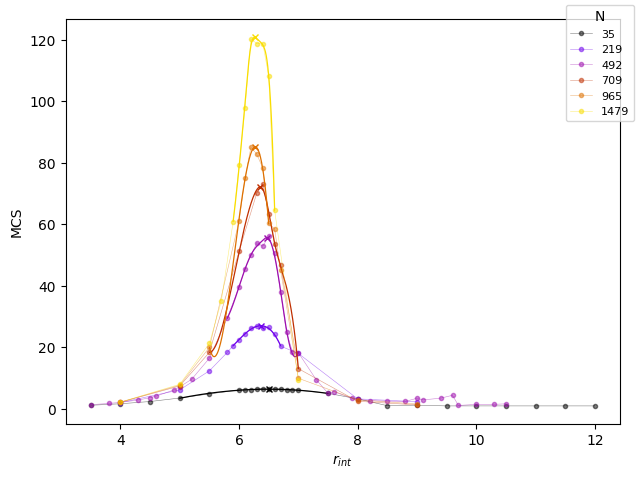

In [5]:
Ns = [35, 219, 492, 709, 965, 1479]
arena_rs = [20.0, 50.0, 75.0, 90.0, 105.0, 130.0]

exclusion_r = 1.5

ss = [1,3,8,5,9,10]
# around_maxs = [7,4,5,3,3,4]
below_maxs = [6,4,6,3,3,3]
above_maxs = [7,4,5,4,3,4]

percs_from_spline_ar_same_dens = meanClusterSize_w_splines_new(arena_rs, exclusion_r, Ns, below_maxs, above_maxs, ss)

[-0.03023883  2.05037674]


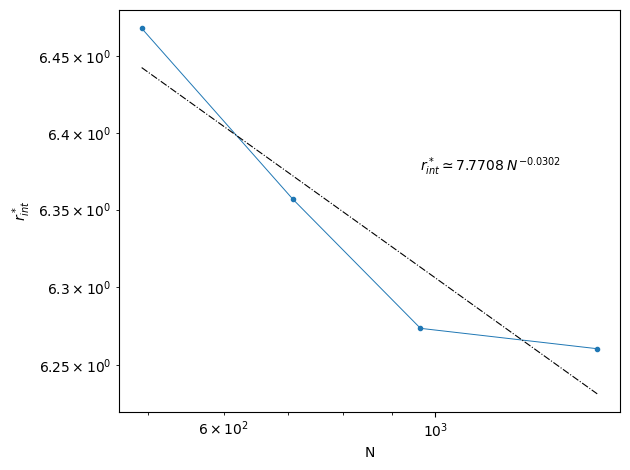

In [8]:
def powerLaw(x,a,b):
    return a*x**b

paramfit = ri_star_N_fit_new(arena_rs[2:], exclusion_r, Ns[2:], percs_from_spline_ar_same_dens[2:], eyerule=None)

print(paramfit)

In [ ]:
def linFunc(x,a,b):
    return a*x+b

p_star_FSC_check(arena_rs, exclusion_r, Ns, percs_from_spline_ar_same_dens, linFunc)

[-0.08993667  1.85447033]
11.118935247630656


[Text(0.5, 0, '$ln \\; N$'), Text(0, 0.5, '$ln \\; p$')]

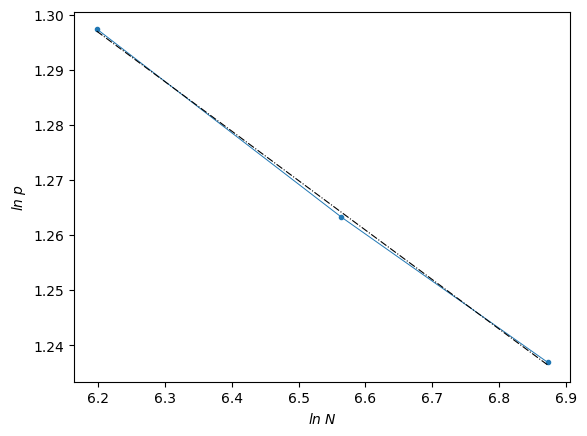

In [16]:
from scipy.optimize import curve_fit
y_axis = [N*(ri/ra)**2 for N,ri,ra in zip(Ns,percs_from_spline_ar_same_dens,arena_rs)]
y_axis_log = [np.log(y) for y in y_axis]
Ns_log = [np.log(N) for N in Ns]

# Ns_log_corr = Ns_log[:2] + Ns_log[4:]
# y_axis_log_corr = y_axis_log[:2] + y_axis_log[4:]

Ns_log_corr = Ns_log[2:-1]
y_axis_log_corr = y_axis_log[2:-1]

fig, ax = plt.subplots()
# ax.plot(Ns_log, y_axis_log, marker='.', lw=0.7)
ax.plot(Ns_log_corr, y_axis_log_corr, marker='.', lw=0.7)

def linFunc(x,a,b):
    return a*x + b

# paramfit, covfit = curve_fit(linFunc, Ns_log, y_axis_log)
paramfit, covfit = curve_fit(linFunc, Ns_log_corr, y_axis_log_corr)
fit = linFunc(np.array(Ns_log_corr), paramfit[0], paramfit[1])
ax.plot(Ns_log_corr, fit, ls='-.', lw=0.8, color='k')
print(paramfit)
print(-1/paramfit[0])
ax.set(xlabel=r'$ln \; N$', ylabel=r'$ln \; p$')

[Text(0.5, 0, '$N^{-1/\\nu}$'), Text(0, 0.5, '$p^*$'), None]

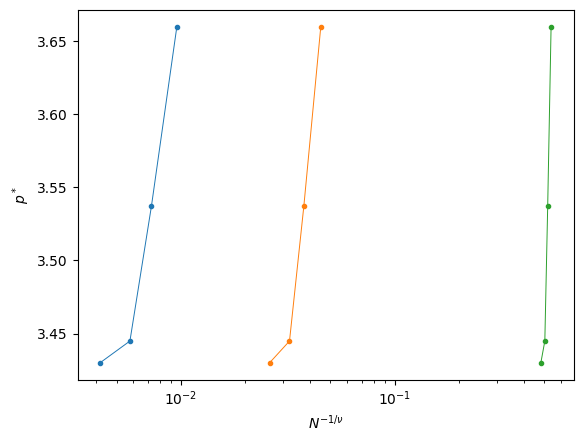

In [13]:
y_axis = [N*(ri/ra)**2 for N,ri,ra in zip(Ns,percs_from_spline_ar_same_dens,arena_rs)]
# y_axis_corr = y_axis[:2] + y_axis[4:]
# Ns_corr = Ns[:2] + Ns[4:]
y_axis_corr = y_axis[2:]
Ns_corr = Ns[2:]

Ns_exp_trial_1 = [N**(-1/(4/3)) for N in Ns_corr]
Ns_exp_trial_2 = [N**(-1/(2.0)) for N in Ns_corr]
Ns_exp_trial_3 = [N**(-1/(10.0)) for N in Ns_corr]


fig, ax = plt.subplots()
ax.plot(Ns_exp_trial_1, y_axis_corr, marker='.', lw=0.7)
ax.plot(Ns_exp_trial_2, y_axis_corr, marker='.', lw=0.7)
ax.plot(Ns_exp_trial_3, y_axis_corr, marker='.', lw=0.7)
ax.set(xlabel=r'$N^{-1/\nu}$', ylabel='$p^*$', xscale='log')